# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [4]:
#cigData.Time = pd.to_datetime(cigData.Time)

In [5]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [6]:
cigData.describe()

,Unnamed: 0,#CigSales
count,144.000000,1.440000e+02
mean,71.500000,1.000280e+06
std,41.713307,1.199663e+02
min,0.000000,1.000104e+06
25%,35.750000,1.000180e+06
50%,71.500000,1.000266e+06
75%,107.250000,1.000360e+06
max,143.000000,1.000622e+06


<AxesSubplot:xlabel='Time'>

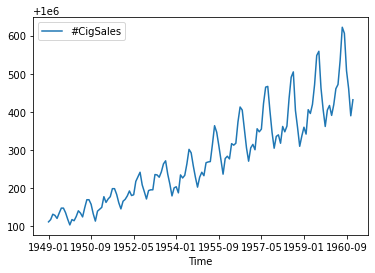

In [7]:
cigData.plot(x='Time', y='#CigSales')
#cigData.plot(y='#CigSales')

### Student note:  The variance of the dataset is not large enough to demonstrate the effect of constant variance after taking the log. The dataset was modified to make it more approporiate for the exercise. The data subtracts 1e+6 and multiplies 1e4.

In [8]:
cigData['#CigSales_altered'] = (cigData['#CigSales'] - 1e6) * 1e4
cigData.head()

,Unnamed: 0,Time,#CigSales,#CigSales_altered
0,0,1949-01,1000112,1120000.0
1,1,1949-02,1000118,1180000.0
2,2,1949-03,1000132,1320000.0
3,3,1949-04,1000129,1290000.0
4,4,1949-05,1000121,1210000.0


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [9]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales', '#CigSales_altered'], dtype='object')

Let's check out the data types of our columns.

In [10]:
cigData.dtypes

Unnamed: 0             int64
Time                  object
#CigSales              int64
#CigSales_altered    float64
dtype: object

Check whether there are any null values. 

In [11]:
cigData.isna().sum()

Unnamed: 0           0
Time                 0
#CigSales            0
#CigSales_altered    0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [12]:
cigData.drop(cigData.columns[0], axis=1, inplace=True)

In [13]:
cigData.head()

,Time,#CigSales,#CigSales_altered
0,1949-01,1000112,1120000.0
1,1949-02,1000118,1180000.0
2,1949-03,1000132,1320000.0
3,1949-04,1000129,1290000.0
4,1949-05,1000121,1210000.0


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [14]:
cigData.rename(columns={'Time':'Month', '#CigSales_altered':'Sales'}, inplace=True)
cigData = cigData.drop(['#CigSales'], axis=1)

Call a head() to check this has worked. 

In [15]:
cigData.head()

,Month,Sales
0,1949-01,1120000.0
1,1949-02,1180000.0
2,1949-03,1320000.0
3,1949-04,1290000.0
4,1949-05,1210000.0


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [16]:
cigData['Month'] = pd.to_datetime(cigData.Month)
cigData.tail()

,Month,Sales
139,1960-08-01,6060000.0
140,1960-09-01,5080000.0
141,1960-10-01,4610000.0
142,1960-11-01,3900000.0
143,1960-12-01,4320000.0


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [17]:
y = cigData['Sales']

Check the type of our new variable. 

In [18]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [19]:
y.describe()

count    1.440000e+02
mean     2.802986e+06
std      1.199663e+06
min      1.040000e+06
25%      1.800000e+06
50%      2.655000e+06
75%      3.605000e+06
max      6.220000e+06
Name: Sales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

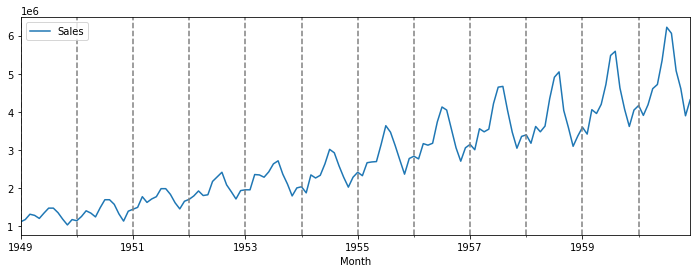

In [20]:
cigData.plot(x='Month', y='Sales',figsize=(12,4))
for year in range(1949, 1962):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='gray', linestyle='--')

### ACF

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

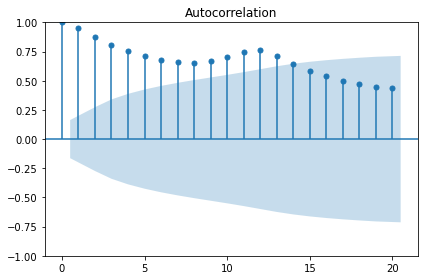

In [22]:
plot_acf(y, lags=20)
plt.tight_layout()

### PACF

C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


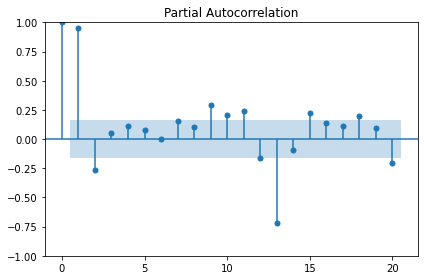

In [23]:
plot_pacf(y, lags=20)
plt.tight_layout()

The PACF plot tells us we may need to have an AR model with lags of 1, 2, 13

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

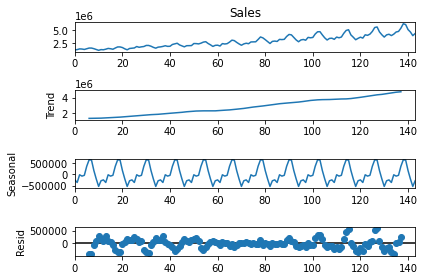

In [25]:
# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = seasonal_decompose(y, period=12, model='additive')
decomposition.plot()
plt.tight_layout()

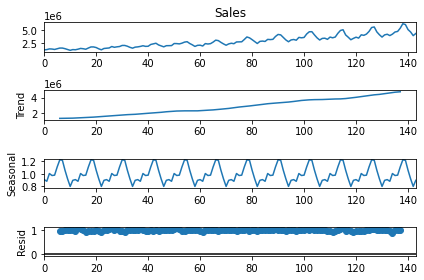

In [26]:
# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = seasonal_decompose(y, period=12, model='multiplicative')
decomposition.plot()
plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [27]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(y, regression='c')
print('kpss result: ')
print(kpss_result)
print('p = ', kpss_result[1])

kpss result: 
(1.6513122354165117, 0.01, 8, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
p =  0.01


C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 


### 3c. Testing for stationarity with adfuller

In [28]:
# use adfuller to check if y is stationary (Null hypothesis here is non-stationary)
from statsmodels.tsa.stattools import adfuller
res = adfuller(y)
print('p is ', res[1])

p is  0.9918802434376424


The p value is greater than 0.05 also suggesting that the time series data in non-stationary.

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

<AxesSubplot:>

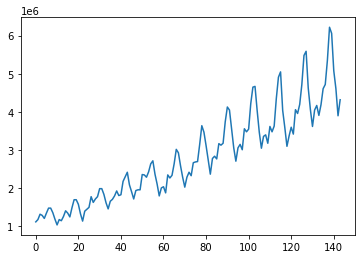

In [29]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [30]:
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

<AxesSubplot:>

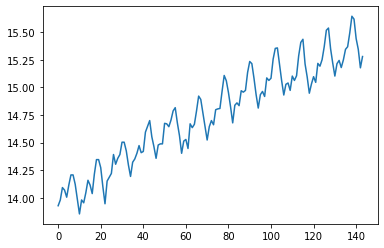

In [31]:
y_log.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [32]:
#test
#first_diffs = cigData.Sales.values[1:] - cigData.Sales.values[:-1]

In [33]:
y_diff = y.diff()
y_diff.dropna(inplace=True)

<AxesSubplot:>

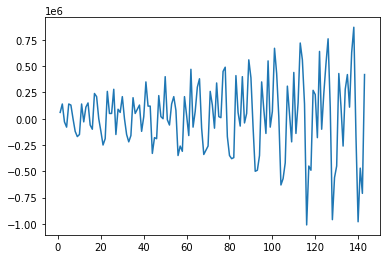

In [34]:
y_diff.plot()

In [35]:
kpss_result = kpss(y_diff, regression='c')
print('kpss result: ')
print(kpss_result)
print('p = ', kpss_result[1])

kpss result: 
(0.023897614400183946, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
p =  0.1


C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [36]:
# adfuller test
result = adfuller(y_diff)
print('p value is ', result[1])

p value is  0.054213290283826696


Adfuller test p value is slightly higher than 0.05 - almost stationary

In [37]:
cigData.set_index('Month', inplace=True)
cigData.head()

,Sales
Month,
1949-01-01,1120000.0
1949-02-01,1180000.0
1949-03-01,1320000.0
1949-04-01,1290000.0
1949-05-01,1210000.0


### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [38]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import datetime
import warnings
warnings.filterwarnings("ignore")

In [39]:
# we will try to model y, y_log, y_log_diff
y_series = cigData.Sales
y_log_series = pd.Series(np.array(y_log), index=cigData.index)
y_diff_series = pd.Series(np.array(y_diff), index=cigData.index[1:])

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [40]:
def split_data(data, train_end_date, test_end_data):
    training_data = data[:train_end_date]
    test_data = data[train_end_date + datetime.timedelta(days=1) : test_end_data]
    return training_data, test_data

In [41]:
def check_arima_model(series, p_vals, d_vals, q_vals, title):
    train_end = datetime.datetime(1959,12,1)
    test_end = datetime.datetime(1960,12,1)
    training, test = split_data(series, train_end, test_end)

    best = float('inf')
    best_p = 0
    best_d = 0
    best_q = 0

    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                    model = ARIMA(training, order=[p,d,q])
                    result = model.fit()

                    test_start = test.index[0]
                    test_end = test.index[-1]

                    test_pred = result.predict(start=test_start, end=test_end)
                    mse = mean_squared_error(test, test_pred)
                    if mse < best:
                        best = mse
                        best_p = p
                        best_d = d
                        best_q = q

    print('The best p, d and q values are: ', best_p, best_d, best_q)
    print('The lowest MSE is: ', best)
    model = ARIMA(training, order=[best_p, best_d, best_q])
    plt.plot(test, label='Sales')
    plt.plot(model.fit().predict(start=test.index[0], end=test.index[-1]), color='r', label='Predicted')
    plt.legend()
    plt.title(title)

In [42]:
p_values = np.arange(0,3)
d_values = np.arange(0,3)
q_values = np.arange(0,3)

The best p, d and q values are:  2 1 2
The lowest MSE is:  326770180879.571


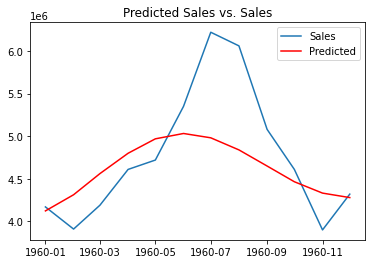

In [43]:
check_arima_model(y_series, p_values, d_values, q_values, 'Predicted Sales vs. Sales')

The best p, d and q values are:  0 2 2
The lowest MSE is:  0.02419102864719652


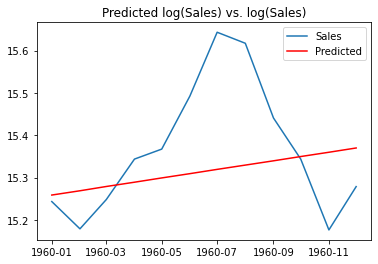

In [44]:
check_arima_model(y_log_series, p_values, d_values, q_values, 'Predicted log(Sales) vs. log(Sales)')

The best p, d and q values are:  2 0 2
The lowest MSE is:  220350982275.7396


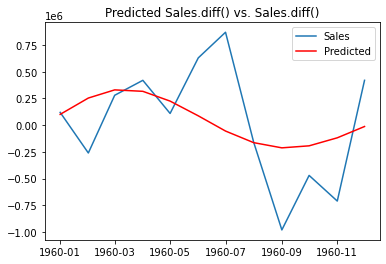

In [45]:
check_arima_model(y_diff_series, p_values, d_values, q_values, 'Predicted Sales.diff() vs. Sales.diff()')

### Student Note: ###
The ARMA models are not predicting the data very well. This may due to the seasonality. We will try the SARIMAX model next which is updated version of ARIMA but handles seasonaility

### 3d. The SARIMAX model 

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Text(0.5, 1.0, 'Predicted Sales vs. Sales')

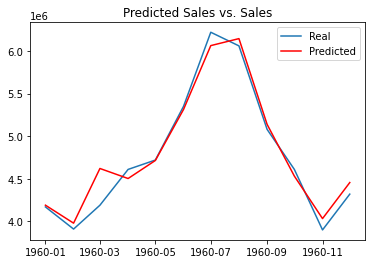

In [47]:
# model on Sales data
train_end = datetime.datetime(1959,12,1)
test_end = datetime.datetime(1960,12,1)
training, test = split_data(y_series, train_end, test_end)

model = SARIMAX(training,order=(2, 1, 2),seasonal_order=(2,1,2,12))
result = model.fit()
result.predict(start=test.index[0], end=test.index[-1])
plt.plot(test, label='Real')
plt.plot(result.predict(start=test.index[0], end=test.index[-1]), color='r', label='Predicted')
plt.legend()
plt.title('Predicted Sales vs. Sales')

Text(0.5, 1.0, 'Predicted log(Sales) vs. log(Sales)')

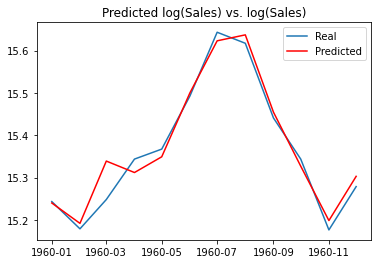

In [48]:
# model on log of Sales data
training, test = split_data(y_log_series, train_end, test_end)

model = SARIMAX(training,order=(2, 0, 2),seasonal_order=(2,0,2,12))
result = model.fit()
#result.summary()
result.predict(start=test.index[0], end=test.index[-1])
plt.plot(test, label='Real')
plt.plot(result.predict(start=test.index[0], end=test.index[-1]), color='r', label='Predicted')
plt.legend()
plt.title('Predicted log(Sales) vs. log(Sales)')

Text(0.5, 1.0, 'Predicted Sales.diff() vs. Sales.diff()')

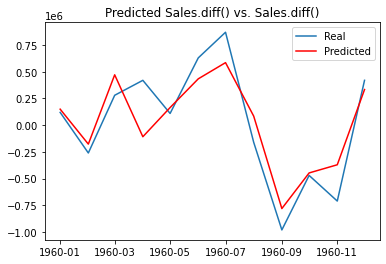

In [49]:
# model on first difference of Sales data
training, test = split_data(y_diff_series, train_end, test_end)

model = SARIMAX(training,order=(2, 0, 2),seasonal_order=(2,0,2,12))
result = model.fit()
#result.summary()
result.predict(start=test.index[0], end=test.index[-1])
plt.plot(test, label='Real')
plt.plot(result.predict(start=test.index[0], end=test.index[-1]), color='r', label='Predicted')
plt.legend()
plt.title('Predicted Sales.diff() vs. Sales.diff()')

### The SARIMAX modle has a much better predicting power than ARIMA model.

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [50]:
# We chose the SARIMAX model trained on Sales data as the final model
# We use all data in model training
training = y_series

model = SARIMAX(training, order=(2, 1, 2),seasonal_order=(2,1,2,12))
result = model.fit()
pred = result.predict(start=test.index[0], end=test.index[-1])

In [51]:
# We will predict for the future 36 months 
forecase_period = 36
future_dates = [datetime.datetime(1961+((m+1)//12),m%12+1,1) for m in np.arange(forecase_period)]
# Convert that range into a dataframe that includes your predictions
pred_future = result.predict(start=future_dates[0], end=future_dates[-1])
pred_future_df = pd.DataFrame(pred_future, index=future_dates)
pred_future_df.columns=['Predict']
pred_future_df.head()

,Predict
1961-01-01,4.435542e+06
1961-02-01,4.164467e+06
1961-03-01,4.552371e+06
1961-04-01,4.857328e+06
1961-05-01,5.000169e+06


<AxesSubplot:>

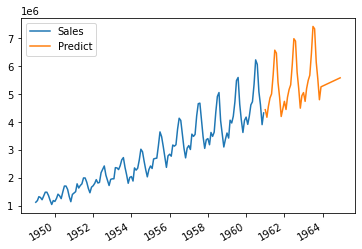

In [52]:
cigData_withFuture = pd.concat([cigData, pred_future_df])
# Plot your future predictions
cigData_withFuture.plot()

### SARIMAX model predicts the future 36 months sale data well.

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

# 5. Student Note
This dataset was altered so that it demonstrate the purpose of this exercise much better (the original dataset has too small variance in the data).
As there is seasonality in the data, ARIMA model does not do a good job predicting future sales. SARIMAX model works much better by taking into account seasonality.